In [1]:
import yaml
import netCDF4 as nc
import numpy as np
from utils.read_data import *
from utils.param_alpha import update_alpha_GD, update_alpha_GD_stockes, update_alpha_GD_wind_only
from models.linear_model import u_drift_linear_matrix, u_drift_ocean_only, u_drift_wind_only
from models.stockes_model import u_drift_ocean_wind_stockes_matrix, u_drift_ocean_stockes_matrix,u_drift_stockes_only
from utils.RK4 import RK4_step, compute_position
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


In [12]:
with open('configs/trace_july2014.yml', 'r') as f:
    config = yaml.safe_load(f)

pos_1, time1 = get_initial_position(config['PATH_DRIFT']) 

true_lon, true_lat, true_time = get_true_drift_positions(config['PATH_DRIFT'])

# Get interpolated initial data
u10_interpolation, v10_interpolation = wind_interpolated(config['PATH_WIND'])
water_u_interpolation, water_v_interpolation = water_interpolated(config['PATH_WATER'])
ust_interpolation, vst_interpolation = wave_interpolated(config['PATH_WAVES'])

# GRADIENT DESCENT ALPHA
alpha = update_alpha_GD(config['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation,alpha = 0.02, theta = 0.349066,  step=0.1, npoints=3)
alpha_stockes = update_alpha_GD_stockes(config['PATH_DRIFT'], water_u_interpolation, water_v_interpolation, u10_interpolation, v10_interpolation, ust_interpolation, vst_interpolation, alpha = 0.005, theta = 0.349066,  step=0.2, npoints=3)
alpha_wind_only = update_alpha_GD_wind_only(config['PATH_DRIFT'], u10_interpolation, v10_interpolation,alpha = 0.02, theta = 0.349066,  step=0.1, npoints=3)

# Drift velocity functions
u_drift = u_drift_linear_matrix(alpha, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation)
u_drift_ocean_wind_stockes = u_drift_ocean_wind_stockes_matrix(alpha_stockes, u10_interpolation, v10_interpolation,water_u_interpolation,water_v_interpolation, ust_interpolation, vst_interpolation)
u_drift_ocean_stockes = u_drift_ocean_stockes_matrix(water_u_interpolation,water_v_interpolation,ust_interpolation, vst_interpolation)
u_drift_wind = u_drift_wind_only(alpha_wind_only,u10_interpolation, v10_interpolation)
u_drift_ocean = u_drift_ocean_only(water_u_interpolation,water_v_interpolation)
u_drift_stockes = u_drift_stockes_only(ust_interpolation, vst_interpolation)



In [13]:
longitudes, latitudes, _ = compute_position(u_drift, pos_1, time1,1,200)
longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes, _ = compute_position(u_drift_ocean_wind_stockes, pos_1, time1,1,200)
longitudes_ocean_stockes, latitudes_ocean_stockes, _ = compute_position(u_drift_ocean_stockes, pos_1, time1,1,200)
longitudes_wind, latitudes_wind, _ = compute_position(u_drift_wind, pos_1, time1,1,200)
longitudes_ocean, latitudes_ocean, _ = compute_position(u_drift_ocean, pos_1, time1,1,200)
longitudes_stockes, latitudes_stockes, _ = compute_position(u_drift_stockes, pos_1, time1,1,200)

Trajectory stopped after  141  hours, Nan values
Trajectory stopped after  141  hours, Nan values
Trajectory stopped after  141  hours, Nan values
Trajectory stopped after  141  hours, Nan values


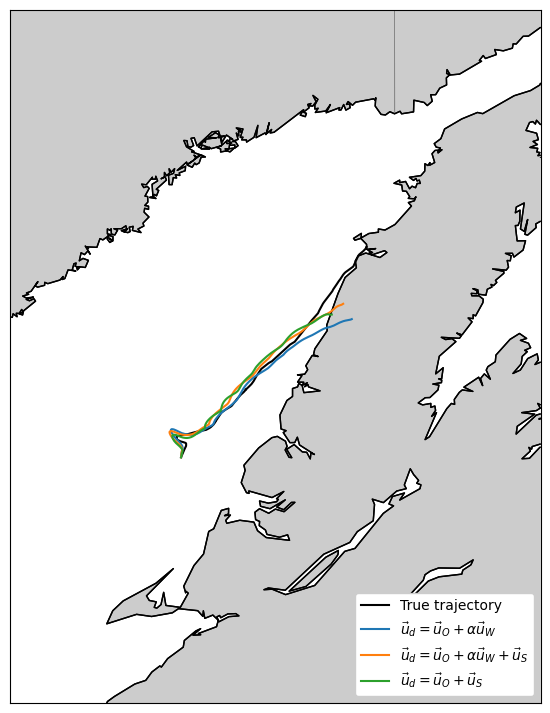

In [14]:
# setting the size of the map
fig = plt.figure(figsize=(12,9))

# creating the map - setting latitude and longitude
#m = Basemap(projection = 'mill', llcrnrlat = 46, urcrnrlat = 50, llcrnrlon = -71, urcrnrlon = -63, resolution = 'i') #august2015
#m = Basemap(projection = 'mill', llcrnrlat = 44, urcrnrlat = 52, llcrnrlon = -74, urcrnrlon = -53, resolution = 'i') 
m = Basemap(projection = 'mill', llcrnrlat = 48, urcrnrlat = 52, llcrnrlon = -60, urcrnrlon = -56, resolution = 'i') #july2014
#m = Basemap(projection = 'mill', llcrnrlat = 46, urcrnrlat = 49, llcrnrlon = -63.5, urcrnrlon = -60, resolution = 'i') #oct2014

# drawing the coastline
m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawcoastlines()
m.fillcontinents()


# plotting the map
#m.scatter(lon, lat, latlon = True, s = 10, c = 'red', marker = '.', alpha = 1)
m.plot(true_lon,true_lat,latlon=True,linewidth=1.5,color='k', label='True trajectory')
#m.scatter(true_lon[0],true_lat[0], latlon=True,s=10,color='g',marker ='o',alpha=1)
m.plot(longitudes,latitudes,latlon=True,linewidth=1.5, label=r'$\vec{u}_d = \vec{u}_O + \alpha \vec{u}_W$')
m.plot(longitudes_ocean_wind_stockes, latitudes_ocean_wind_stockes,latlon=True,linewidth=1.5,label=r'$\vec{u}_d = \vec{u}_O + \alpha \vec{u}_W+ \vec{u}_S$')
m.plot(longitudes_ocean_stockes, latitudes_ocean_stockes,latlon=True,linewidth=1.5, label=r'$\vec{u}_d = \vec{u}_O + \vec{u}_S$')
#m.plot(longitudes_wind, latitudes_wind,latlon=True,linewidth=1.5,label=r'$\vec{u}_d = \alpha \vec{u}_W$')
#m.plot(longitudes_ocean, latitudes_ocean,latlon=True,linewidth=1.5, label=r'$\vec{u}_d = \vec{u}_O$')
#m.plot(longitudes_stockes, latitudes_stockes,latlon=True,linewidth=1.5, label=r'$\vec{u}_d = \vec{u}_S$')

#plot grid ocean
#m.scatter(gridx_wind,gridy_wind,latlon=True,s=10,color='k',marker ='+',alpha=0.5, label='Grid for wind data')

plt.legend(loc = 'lower right',framealpha=1)
plt.show()
